**Imports**

In [53]:
import numpy as np 
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix, \
                            mean_absolute_error, fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, \
                                    RandomizedSearchCV, StratifiedKFold, StratifiedShuffleSplit

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, Trials
from xgboost import XGBClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

**Ingest**

In [4]:
df = pd.read_csv('online_fraud.csv')

In [5]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
print(df.isFraud.value_counts(normalize=True))
print(df.isFraud.value_counts(normalize=False))

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [9]:
print(df.isFlaggedFraud.value_counts(normalize=True))
print(df.isFlaggedFraud.value_counts(normalize=False))

isFlaggedFraud
0    0.999997
1    0.000003
Name: proportion, dtype: float64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


**EDA**

"""
Seems like Fraud labels are highly skewed and flagged_fraud are even more.

Ideally we can base our study/EDA on why this fruad to fraud flagging funnel flows!
- Why so steep falloff from fraud to flagged_fraud?
- What params effect flagged_fraud cases?
"""

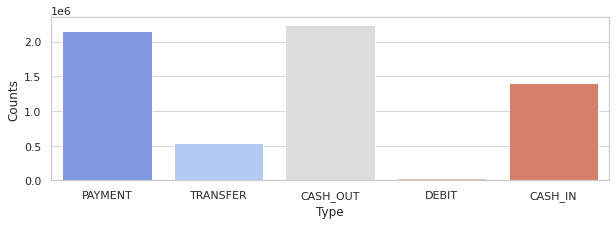

In [17]:
plt.figure(figsize=(10,3))
sns.countplot(data = df , palette='coolwarm' , x = 'type')
plt.xlabel('Type')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.8)
plt.show()

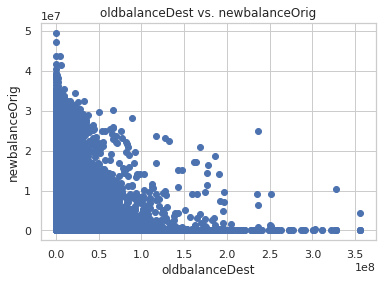

In [18]:
plt.scatter(df['oldbalanceDest'], df['newbalanceOrig'], label='Data')
plt.xlabel('oldbalanceDest')
plt.ylabel('newbalanceOrig')
plt.title('oldbalanceDest vs. newbalanceOrig')
plt.grid(True)
plt.show()

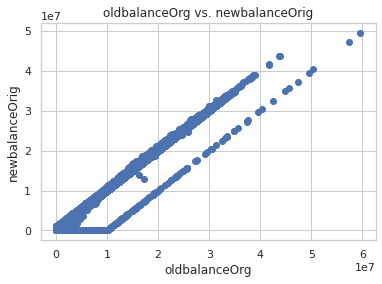

In [19]:
plt.scatter(df['oldbalanceOrg'], df['newbalanceOrig'], label='Data')
plt.xlabel('oldbalanceOrg')
plt.ylabel('newbalanceOrig')
plt.title('oldbalanceOrg vs. newbalanceOrig')
plt.grid(True)
plt.show()

**Pre-Processing**

In [20]:
df.shape

(6362620, 11)

In [21]:
len(df.type.unique())

5

In [22]:
len(df.nameOrig.unique())

6353307

In [23]:
len(df.nameDest.unique())

2722362

In [24]:
df[['nameOrig', 'nameDest',  'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].sample(10)

,nameOrig,nameDest,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
5178269,C312095651,C932707776,39203.49,0.00,0.00,2175822.92,2215026.41
2289733,C1937041896,C11139703,10819.44,41564.00,52383.44,4069180.05,4058360.61
3989792,C121572396,C1658563578,508291.14,39998.00,0.00,3463.66,511754.80
2165054,C267617443,C2130147842,83206.90,8500.00,0.00,38284.71,121491.61
5971165,C330420663,C1781254903,294688.27,20167.00,0.00,54225.78,348914.05
631912,C1100638369,C1942221275,52742.79,30996.00,83738.79,0.00,0.00
5171403,C1206425287,M1723804449,5352.50,59178.80,53826.30,0.00,0.00
3513891,C1121184963,M182625373,13485.46,1505.49,0.00,0.00,0.00
6192336,C430928857,C391677262,415636.39,420883.00,5246.61,0.00,415636.39
5249879,C993202189,M458701576,13236.12,0.00,0.00,0.00,0.00


In [25]:
df[df.newbalanceDest == 0.0].shape

(2439433, 11)

In [27]:
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
                'oldbalanceDest', 'newbalanceDest']

cat_cols = ['type']

label = 'isFraud'
ground_label = 'isFlaggedFraud'

In [28]:
df.type.value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [29]:
# encode type: <logic: onehot encoding>

# oe = OneHotEncoder()
df_encoded = pd.get_dummies(df, prefix=['type'], columns = ['type'], drop_first=False)

In [30]:
df_encoded.shape

(6362620, 15)

In [31]:
df_encoded.columns

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [32]:
encoded_cols = ['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']

**Data Creation**

In [33]:
X = df_encoded[numeric_cols + encoded_cols]
y = df_encoded[[label]]

X.shape, y.shape

((6362620, 11), (6362620, 1))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=42, # for reproducibility
                                                   )
print('x_train shape is ' , x_train.shape)
print('x_test shape is ' , x_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

x_train shape is  (4453834, 11)
x_test shape is  (1908786, 11)
y_train shape is  (4453834, 1)
y_test shape is  (1908786, 1)


**Feature Selection**

In [35]:
# no class weight
rf_clf1 = RandomForestClassifier(n_estimators=100, 
                                 max_depth=10, 
                                 n_jobs=-1, 
                                 random_state=42, 
                                 class_weight=None
                                )

rf_clf1.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

In [36]:
y_pred_tr = rf_clf1.predict_proba(x_train)
y_pred = rf_clf1.predict_proba(x_test)

print(f"RF AUC train set: {roc_auc_score(y_train, y_pred_tr[:, 1])}")
print(f"RF AUC train set: {roc_auc_score(y_test, y_pred[:, 1])}")

print(f"RF ACCURACY train set: {accuracy_score(y_train, rf_clf1.predict(x_train))}")
print(f"RF ACCURACY test set: {accuracy_score(y_test, rf_clf1.predict(x_test))}")

RF AUC train set: 0.9973849932089492
RF AUC train set: 0.996559149762478
RF ACCURACY train set: 0.9996405344249472
RF ACCURACY test set: 0.9996269880437094


In [37]:
# feat_imp = map(list(df_encoded.columns), list(rf_clf1.feature_importances_))
# print(feat_imp)

df_feat_imp = pd.DataFrame(data=pd.concat([pd.Series(X.columns), pd.Series(rf_clf1.feature_importances_)], axis=1))
df_feat_imp.columns = ['Features', 'Importance_score']

In [38]:
df_feat_imp

,Features,Importance_score
0,step,0.074575
1,amount,0.134617
2,oldbalanceOrg,0.278464
3,newbalanceOrig,0.039642
4,oldbalanceDest,0.059440
5,newbalanceDest,0.318241
6,type_CASH_IN,0.004966
7,type_CASH_OUT,0.032396
8,type_DEBIT,0.000079
9,type_PAYMENT,0.002634


In [ ]:
"""
We are not eliminating any features in this case.
"""

**Fit XGBoost**

In [39]:
xgb_clf = xgb.XGBClassifier(booster='gbtree', 
                            n_estimators=200, 
                            max_depth=10, 
                            learning_rate=0.01, 
                            tree_method='hist', 
                            n_jobs=-1, 
                            # scale_pos_weight, 
                            random_state=42, 
                           )

xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [40]:
y_pred_tr = xgb_clf.predict_proba(x_train)
y_pred = xgb_clf.predict_proba(x_test)

print(f"XGB AUC train set: {roc_auc_score(y_train, y_pred_tr[:, 1])}")
print(f"XGB AUC train set: {roc_auc_score(y_test, y_pred[:, 1])}")

print(f"XGB ACCURACY train set: {accuracy_score(y_train, xgb_clf.predict(x_train))}")
print(f"XGB ACCURACY test set: {accuracy_score(y_test, xgb_clf.predict(x_test))}")

XGB AUC train set: 0.998531379075609
XGB AUC train set: 0.9981873355506015
XGB ACCURACY train set: 0.9996699472858666
XGB ACCURACY test set: 0.9996463720919998


In [41]:
print(classification_report(y_true=y_test, y_pred=xgb_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.74      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



In [42]:
print(confusion_matrix(y_true=y_test, y_pred=xgb_clf.predict(x_test)))

[[1906286      36]
 [    639    1825]]


In [43]:
xgb_clf.feature_importances_

array([0.01784205, 0.04813153, 0.15989871, 0.11321739, 0.05575914,
       0.4741771 , 0.        , 0.03661154, 0.00630376, 0.0182411 ,
       0.06981769], dtype=float32)

In [44]:
df_xgb_feat_imp = pd.DataFrame(data=pd.concat([pd.Series(X.columns), pd.Series(xgb_clf.feature_importances_)], axis=1))
df_xgb_feat_imp.columns = ['Features', 'Importance_score']
df_xgb_feat_imp

,Features,Importance_score
0,step,0.017842
1,amount,0.048132
2,oldbalanceOrg,0.159899
3,newbalanceOrig,0.113217
4,oldbalanceDest,0.055759
5,newbalanceDest,0.474177
6,type_CASH_IN,0.000000
7,type_CASH_OUT,0.036612
8,type_DEBIT,0.006304
9,type_PAYMENT,0.018241


**Hyperparameter Tuning**

In [54]:
def objective(params):
 
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        scale_pos_weight=params['scale_pos_weight'],
        use_label_encoder=False 
    )
    

    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)

    return -auc_score


In [55]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.001), np.log(1.0)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(1.0)),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 3)
}


In [56]:
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50, 
    trials=trials
)

print("Best Hyperparameters:")
print(best)

100%|█████| 50/50 [1:25:13<00:00, 102.28s/trial, best loss: -0.9998298271641521]
Best Hyperparameters:
{'colsample_bytree': 0.9972775414874905, 'gamma': 0.33025071660188887, 'learning_rate': 0.1154549304425997, 'max_depth': 8.0, 'n_estimators': 800.0, 'reg_alpha': 0.9412947581254824, 'reg_lambda': 0.5971265860700231, 'scale_pos_weight': 2.476501599045624, 'subsample': 0.9857996925389791}


In [59]:
xgb_clf1 = xgb.XGBClassifier(booster='gbtree', 
                            tree_method='hist', 
                            n_jobs=-1,
                            random_state=42,
                            colsample_bytree=0.9972775414874905,
                            gamma= 0.33025071660188887,
                            learning_rate= 0.1154549304425997,
                            max_depth= 8,
                            n_estimators= 800,
                            reg_alpha= 0.9412947581254824,
                            reg_lambda= 0.5971265860700231,
                            scale_pos_weight= 2.476501599045624,
                            subsample= 0.9857996925389791
                           )

xgb_clf1.fit(x_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9972775414874905, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.33025071660188887,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1154549304425997,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [60]:
y_pred_tr = xgb_clf1.predict_proba(x_train)
y_pred = xgb_clf1.predict_proba(x_test)

print(f"XGB AUC train set: {roc_auc_score(y_train, y_pred_tr[:, 1])}")
print(f"XGB AUC train set: {roc_auc_score(y_test, y_pred[:, 1])}")

print(f"XGB ACCURACY train set: {accuracy_score(y_train, xgb_clf1.predict(x_train))}")
print(f"XGB ACCURACY test set: {accuracy_score(y_test, xgb_clf1.predict(x_test))}")

XGB AUC train set: 0.9999966003495325
XGB AUC train set: 0.9998389896879961
XGB ACCURACY train set: 0.9999315196749587
XGB ACCURACY test set: 0.9997694869933036


In [61]:
print(classification_report(y_true=y_test, y_pred=xgb_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.74      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



In [63]:
cm=confusion_matrix(y_true=y_test, y_pred=xgb_clf.predict(x_test))

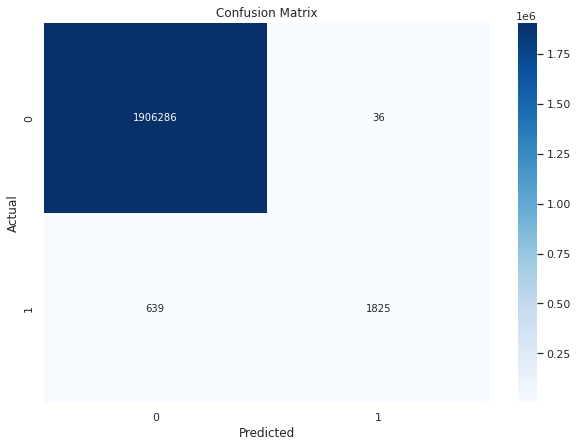

In [64]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()